In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from os.path import exists, join
import xarray as xr
import pandas as pd
from glob import glob
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from matplotlib.colors import LogNorm
from IPython.display import Image
from hagelslag.evaluation.ProbabilityMetrics import DistributedROC, DistributedReliability
from hagelslag.evaluation.MetricPlotter import roc_curve, performance_diagram, attributes_diagram

In [3]:
def load_storm_patch_data(data_path, variable_names):
    data_patches = []
    centers = []
    valid_dates = []
    data_files = sorted(glob(join(data_path, "*.nc")))
    for data_file in data_files:
        print(data_file)
        ds = xr.open_dataset(data_file)
        patch_arr = []
        all_vars = list(ds.variables.keys())
        if np.all(np.in1d(variable_names, all_vars)):
            centers.append(np.array([ds["longitude"][:, 32, 32], ds["latitude"][:, 32, 32]]).T)
            valid_dates.append(ds["valid_date"].values)
            for variable in variable_names:
                patch_arr.append(ds[variable].values)
            data_patches.append(np.stack(patch_arr, axis=-1))
        ds.close()
    center_arr = np.vstack(centers)
    valid_date_index = pd.DatetimeIndex(np.concatenate(valid_dates))
    data = np.vstack(data_patches)
    return data, center_arr, valid_date_index

In [7]:
data = xr.open_dataset("/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016052600_mem_09.nc")

In [8]:
all_vars = list(data.variables.keys())

['longitude',
 'latitude',
 'p',
 'y',
 'x',
 'row',
 'column',
 'forecast_hour',
 'valid_date',
 'run_date',
 'mask',
 'hourly_maximum_of_upward_vertical_velocity_in_the_lowest_400hpa_400-1000_mb_above_ground',
 'composite_reflectivity_entire_atmosphere_current',
 'reflectivity_263_k_level_current',
 'wind_speed_(gust)_surface_current',
 'hourly_maximum_of_downward_vertical_velocity_in_the_lowest_400hpa_400-1000_mb_above_ground_current',
 'reflectivity_4000_m_above_ground_current',
 'reflectivity_1000_m_above_ground_current',
 'hourly_maximum_of_simulated_reflectivity_at_1_km_agl_1000_m_above_ground_current',
 'hourly_maximum_of_updraft_helicity_over_layer_2km_to_5_km_agl_5000-2000_m_above_ground_current',
 'total_column_integrate_graupel_entire_atmosphere_(considered_as_a_single_layer)_current',
 'geopotential_height_surface_current',
 'wind_speed_10_m_above_ground_current',
 'total_precipitation_surface_current',
 'thompson_max_hail_k1_surface_current',
 'thompson_max_hail_2d_surfac

In [4]:
all_vars = list(data.variables.keys())
variable_names = ['composite_reflectivity_entire_atmosphere_current',
                  'precipitable_water_entire_atmosphere_(considered_as_a_single_layer)_current',
                  'convective_available_potential_energy_180-0_mb_above_ground_prev',
                  'vertical_u-component_shear_0-6000_m_above_ground_prev',
                  'vertical_v-component_shear_0-6000_m_above_ground_prev',
                  ]
np.all(np.in1d(variable_names, all_vars))

NameError: name 'data' is not defined

In [5]:
variable_names = ['composite_reflectivity_entire_atmosphere_current',
                  'precipitable_water_entire_atmosphere_(considered_as_a_single_layer)_current',
                  'convective_available_potential_energy_180-0_mb_above_ground_prev',
                  'vertical_u-component_shear_0-6000_m_above_ground_prev',
                  'vertical_v-component_shear_0-6000_m_above_ground_prev',
                  ]
storm_data, storm_centers, storm_dates = load_storm_patch_data("/scratch/dgagne/ncar_ens_storm_patches/", variable_names)

/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050300_mem_01.nc
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050300_mem_02.nc
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050300_mem_03.nc
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050300_mem_04.nc
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050300_mem_05.nc
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050300_mem_06.nc
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050300_mem_07.nc
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050300_mem_08.nc
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050300_mem_09.nc
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050300_mem_10.nc
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050400_mem_01.nc
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050400_mem_02.nc
/scr

In [6]:
storm_reports = pd.read_csv("http://www.spc.noaa.gov/wcm/data/2016_hail.csv", parse_dates={"datetime":["date", "time"]})
severe_reports = storm_reports.loc[storm_reports["mag"] >= 1]
severe_reports = severe_reports.reset_index()

In [36]:
severe_reports.columns

Index(['datetime', 'om', 'yr', 'mo', 'dy', 'tz', 'st', 'stf', 'stn', 'mag',
       'inj', 'fat', 'loss', 'closs', 'slat', 'slon', 'elat', 'elon', 'len',
       'wid', 'ns', 'sn', 'sg', 'f1', 'f2', 'f3', 'f4'],
      dtype='object')

In [7]:
def gc_distance(lon_1, lat_1, lon_2, lat_2):
    inv_lat_1 = np.radians(90 - lat_1)
    inv_lat_2 = np.radians(90 - lat_2)
    lon_1_rad = np.radians(lon_1)
    lon_2_rad = np.radians(lon_2)
    radius = 6373.0
    arc = np.arccos(np.sin(inv_lat_1) * np.sin(inv_lat_2) * np.cos(lon_1_rad - lon_2_rad) + np.cos(inv_lat_1) * np.cos(inv_lat_2))
    return radius * arc

In [63]:
severe_reports.shape

(7269, 27)

In [57]:
tdiff = pd.TimedeltaIndex(np.abs(severe_reports["datetime"].values - np.datetime64(storm_dates[0])))
tdiff.total_seconds() / 3600

array([ 2779.05      ,  2779.        ,  2779.        , ...,  5739.36666667,
        5740.41666667,  5740.65      ])

In [8]:
has_severe_hail = np.zeros(storm_dates.size)
min_severe_hail_distance = np.ones(storm_dates.size) * np.nan
min_times = np.ones(storm_dates.size)
for s in range(has_severe_hail.size):
    tdiff = pd.TimedeltaIndex(np.abs(severe_reports["datetime"].values - np.datetime64(storm_dates.values[s])))
    valid_times = np.where((tdiff.total_seconds() / 3600) < 4)[0]
    min_times[s] = (tdiff.total_seconds() / 3600).min()
    if len(valid_times) > 0:
        has_severe_hail[s] = np.count_nonzero(gc_distance(storm_centers[s, 0], 
                                                      storm_centers[s, 1], 
                                                      severe_reports.loc[valid_times, "slon"], 
                                                      severe_reports.loc[valid_times, "slat"]) < 40)
        min_severe_hail_distance[s] = gc_distance(storm_centers[s, 0], 
                                                   storm_centers[s, 1], 
                                                   severe_reports.loc[valid_times, "slon"], 
                                                   severe_reports.loc[valid_times, "slat"]).min()

In [56]:
min_severe_hail_distance

array([  126.93612312,    41.01939808,    58.74389546, ...,  1353.77101857,
        1421.17428672,  1379.95164245])

(array([  684.,  1396.,  1752.,  1986.,  2162.,  2256.,  2384.,  2374.,
         2405.,  2451.,  2421.,  2438.,  2390.,  2239.,  2118.,  1957.,
         2053.,  1963.,  1857.]),
 array([  0,  10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120,
        130, 140, 150, 160, 170, 180, 190]),
 <a list of 19 Patch objects>)

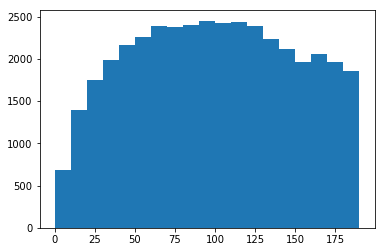

In [61]:
plt.hist(min_severe_hail_distance[~np.isnan(min_severe_hail_distance)], 
         bins=np.arange(0, 200, 10), cumulative=False)

(array([ 62031.,  12714.,  10564.,   8643.,   7649.,   5215.,   2950.,
          1658.,   1225.,    463.]),
 array([  0.        ,   1.05833333,   2.11666667,   3.175     ,
          4.23333333,   5.29166667,   6.35      ,   7.40833333,
          8.46666667,   9.525     ,  10.58333333]),
 <a list of 10 Patch objects>)

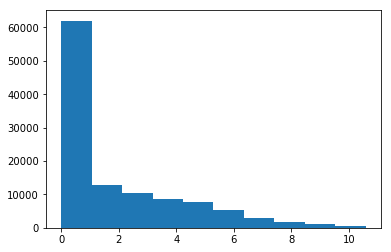

In [62]:
plt.hist(min_times)

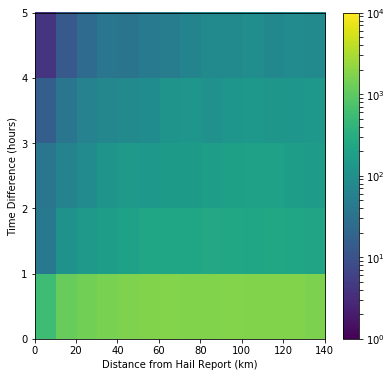

In [54]:
plt.figure(figsize=(6.5, 6))
plt.hist2d(min_severe_hail_distance, min_times, 
           bins=[np.arange(0, 150, 10), np.arange(0, 6, 1)], 
           norm=LogNorm(vmin=1, vmax=10000),cmin=1)
plt.colorbar()
plt.gca().set(xlabel="Distance from Hail Report (km)", ylabel="Time Difference (hours)")

In [157]:
np.nanpercentile(min_severe_hail_distance, 10)

81.685311658436007

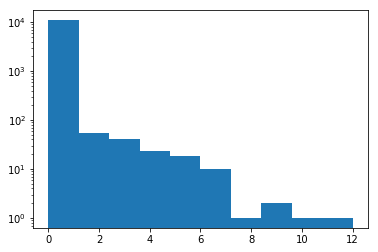

In [158]:
plt.hist(has_severe_hail)
plt.gca().set_yscale("log")

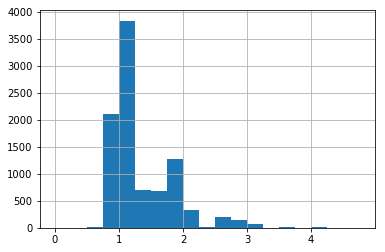

In [32]:
storm_reports["mag"].hist(bins=np.arange(0, 5, 0.25))

(array([ 12008057.,   3733178.,   5540028.,   6935915.,   6556225.,
          6588118.,   2745624.,    878621.,    228162.,     18200.]),
 array([-20.     ,  -9.75625,   0.4875 ,  10.73125,  20.975  ,  31.21875,
         41.4625 ,  51.70625,  61.95   ,  72.19375,  82.4375 ]),
 <a list of 10 Patch objects>)

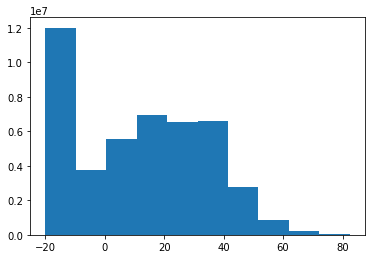

In [106]:
plt.hist(storm_data[:, :, :, 0].ravel())

In [32]:
storm_data[:, :, :, 4].mean()

3.8873699

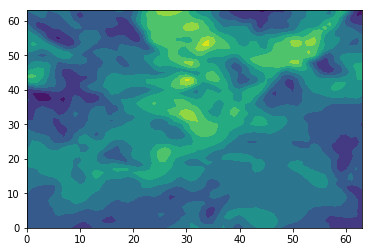

In [83]:
plt.contourf(storm_data[355, :, :, 1])

In [74]:
cape_sqrt = np.sqrt(storm_data[:, :, :, 2].reshape(storm_data.shape[0], 64 * 64))


In [75]:
pc = PCA(n_components=10)
pc.fit((cape_sqrt - cape_sqrt.mean()) / cape_sqrt.std())

PCA(copy=True, iterated_power='auto', n_components=10, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

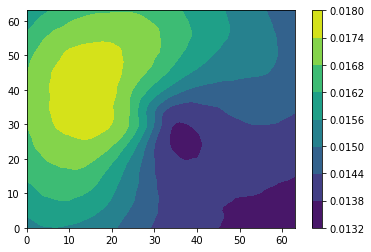

In [78]:
plt.contourf(pc_objs[2].components_[0].reshape(64,64))
plt.colorbar()

In [20]:
unique_storm_dates = np.unique(storm_dates.date)
shuffled_storm_dates = np.random.permutation(unique_storm_dates)
split_point = int(0.7 * len(shuffled_storm_dates))
train_dates = np.sort(shuffled_storm_dates[:split_point])
test_dates = np.sort(shuffled_storm_dates[split_point:])
train_indices = np.where(np.in1d(storm_dates.date, train_dates))[0]
test_indices = np.where(np.in1d(storm_dates.date, test_dates))[0]

In [21]:
pc_objs = []
means = []
sds = []
num_comps = 10
num_vars = 5
pc_train_data = np.zeros((train_indices.size, num_comps * num_vars))
pc_test_data = np.zeros((test_indices.size, num_comps * num_vars))
for v in range(num_vars):
    print(v)
    pc_objs.append(PCA(n_components=10))
    if v == 2:
        var_data = np.sqrt(storm_data[:, :, :, v].reshape(-1, 64 * 64))
    else:
        var_data = storm_data[:, :, :, v].reshape(-1, 64 * 64)
    means.append(var_data.mean())
    sds.append(var_data.std())
    norm_data = (var_data - means[v]) / sds[v]
    pc_train_data[:, v * 10: (v + 1) * 10] = pc_objs[v].fit_transform(norm_data[train_indices])
    pc_test_data[:, v * 10: (v + 1) * 10] = pc_objs[v].transform(norm_data[test_indices])

0
1
2
3
4


In [108]:
mv_means = []
mv_sds = []
num_comps = 20
num_vars = 5
mv_pc_obj = PCA(n_components=num_comps)
mv_pc_train_data = np.zeros((train_indices.size, num_comps))
mv_pc_test_data = np.zeros((test_indices.size, num_comps))
mv_norm_data = np.zeros((storm_data.shape[0], 64 * 64 * num_vars))
for v in range(num_vars):
    print(v)
    #pc_objs.append(PCA(n_components=10))
    if v == 2:
        var_data = np.sqrt(storm_data[:, :, :, v].reshape(-1, 64 * 64))
    else:
        var_data = storm_data[:, :, :, v].reshape(-1, 64 * 64)
    mv_means.append(var_data.mean())
    mv_sds.append(var_data.std())
    mv_norm_data[:, 64 * 64 * v: 64 * 64 * (v + 1)] = (var_data - means[v]) / sds[v]
mv_pc_train_data[:, :] = mv_pc_obj.fit_transform(mv_norm_data[train_indices])
mv_pc_test_data[:, :] = mv_pc_obj.transform(mv_norm_data[test_indices])

0
1
2
3
4


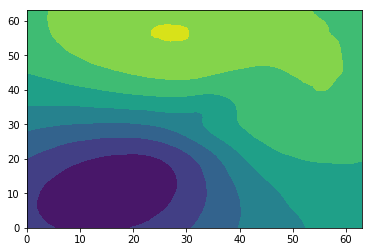

In [101]:
plt.contourf(mv_pc_obj.components_[9][4096*0:4096 * 1].reshape(64,64))

In [109]:
mv_pc_obj.explained_variance_ratio_

array([ 0.2296561 ,  0.15311413,  0.1262307 ,  0.0585769 ,  0.04100253,
        0.02968698,  0.02317012,  0.02231816,  0.01722341,  0.01589493,
        0.01336611,  0.01279727,  0.00950849,  0.00856528,  0.0075927 ,
        0.00643132,  0.00599934,  0.00566188,  0.0054779 ,  0.00475419])

In [105]:
min_severe_hail_distance[np.isnan(min_severe_hail_distance)] = 9999999
train_labels = np.where(min_severe_hail_distance[train_indices] < 160, 1, 0)
test_labels = np.where(min_severe_hail_distance[test_indices] < 160, 1, 0)

In [110]:
rf_mv = RandomForestClassifier(n_estimators=500, n_jobs=4, max_features="sqrt")
rf_mv.fit(mv_pc_train_data, train_labels)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=4, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [111]:
rf_mv.feature_importances_

array([ 0.07199502,  0.08695659,  0.06416411,  0.0905009 ,  0.08478787,
        0.04329928,  0.04035167,  0.04413879,  0.04231624,  0.04136331,
        0.04435013,  0.04070406,  0.0387958 ,  0.04461765,  0.03783802,
        0.03750421,  0.03682689,  0.03807388,  0.03598682,  0.03542878])

In [30]:
rf = RandomForestClassifier(n_estimators=500, n_jobs=4, max_features="sqrt")
rf.fit(pc_train_data, train_labels)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=4, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [31]:
rf_preds = rf.predict_proba(pc_test_data)[:, 1]

(array([ 1686.,  5554.,  7960.,  7711.,  6120.,  3884.,  2093.,   904.,
          236.,    29.]),
 array([ 0.002 ,  0.0922,  0.1824,  0.2726,  0.3628,  0.453 ,  0.5432,
         0.6334,  0.7236,  0.8138,  0.904 ]),
 <a list of 10 Patch objects>)

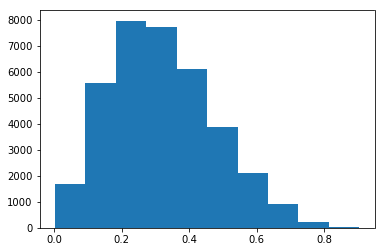

In [27]:
plt.hist(rf_preds)

In [32]:
logit = LogisticRegression(penalty="l1")
logit.fit(pc_train_data, train_labels)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [33]:
logit_preds = logit.predict_proba(pc_test_data)[:, 1]

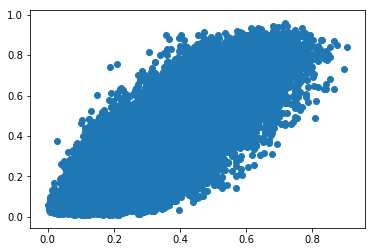

In [26]:
plt.scatter(rf_preds, logit_preds)

In [34]:
logit.coef_

array([[ 0.00410254, -0.00206951, -0.00654126,  0.00235539, -0.00701154,
         0.00216319, -0.00476771,  0.00142651,  0.00610242, -0.00016836,
         0.01656552,  0.02712975,  0.00357492,  0.0206493 ,  0.02383388,
        -0.01684514, -0.00341637,  0.0062114 , -0.00365573, -0.00946042,
         0.01847374, -0.00182606,  0.00297849,  0.00362054, -0.01020593,
         0.01486102, -0.00443039, -0.00279718, -0.00404756,  0.00174898,
        -0.00894072,  0.00694267,  0.00787597, -0.00852641, -0.00061422,
         0.00285988,  0.00311282,  0.00044144,  0.00055422,  0.00997964,
         0.0040147 ,  0.0025486 ,  0.00763022, -0.00820168,  0.01043601,
         0.00249809,  0.00232485, -0.00380224, -0.0044822 , -0.00505782]])

In [38]:
rf_roc = DistributedROC()
rf_roc.update(rf_preds, test_labels)
logit_roc = DistributedROC()
logit_roc.update(logit_preds, test_labels)
print(rf_roc.auc(), logit_roc.auc())

0.670266096614 0.658386848658


In [41]:
roc_curve([rf_roc, logit_roc], ["Random Forest", "Logistic Regression"], ["red", "blue"],
          ["o", "v"], "hail_prob_roc.png", figsize=(6, 6), 
          title="NCAR Storm Patch Severe Hail Probability ROC Curve")

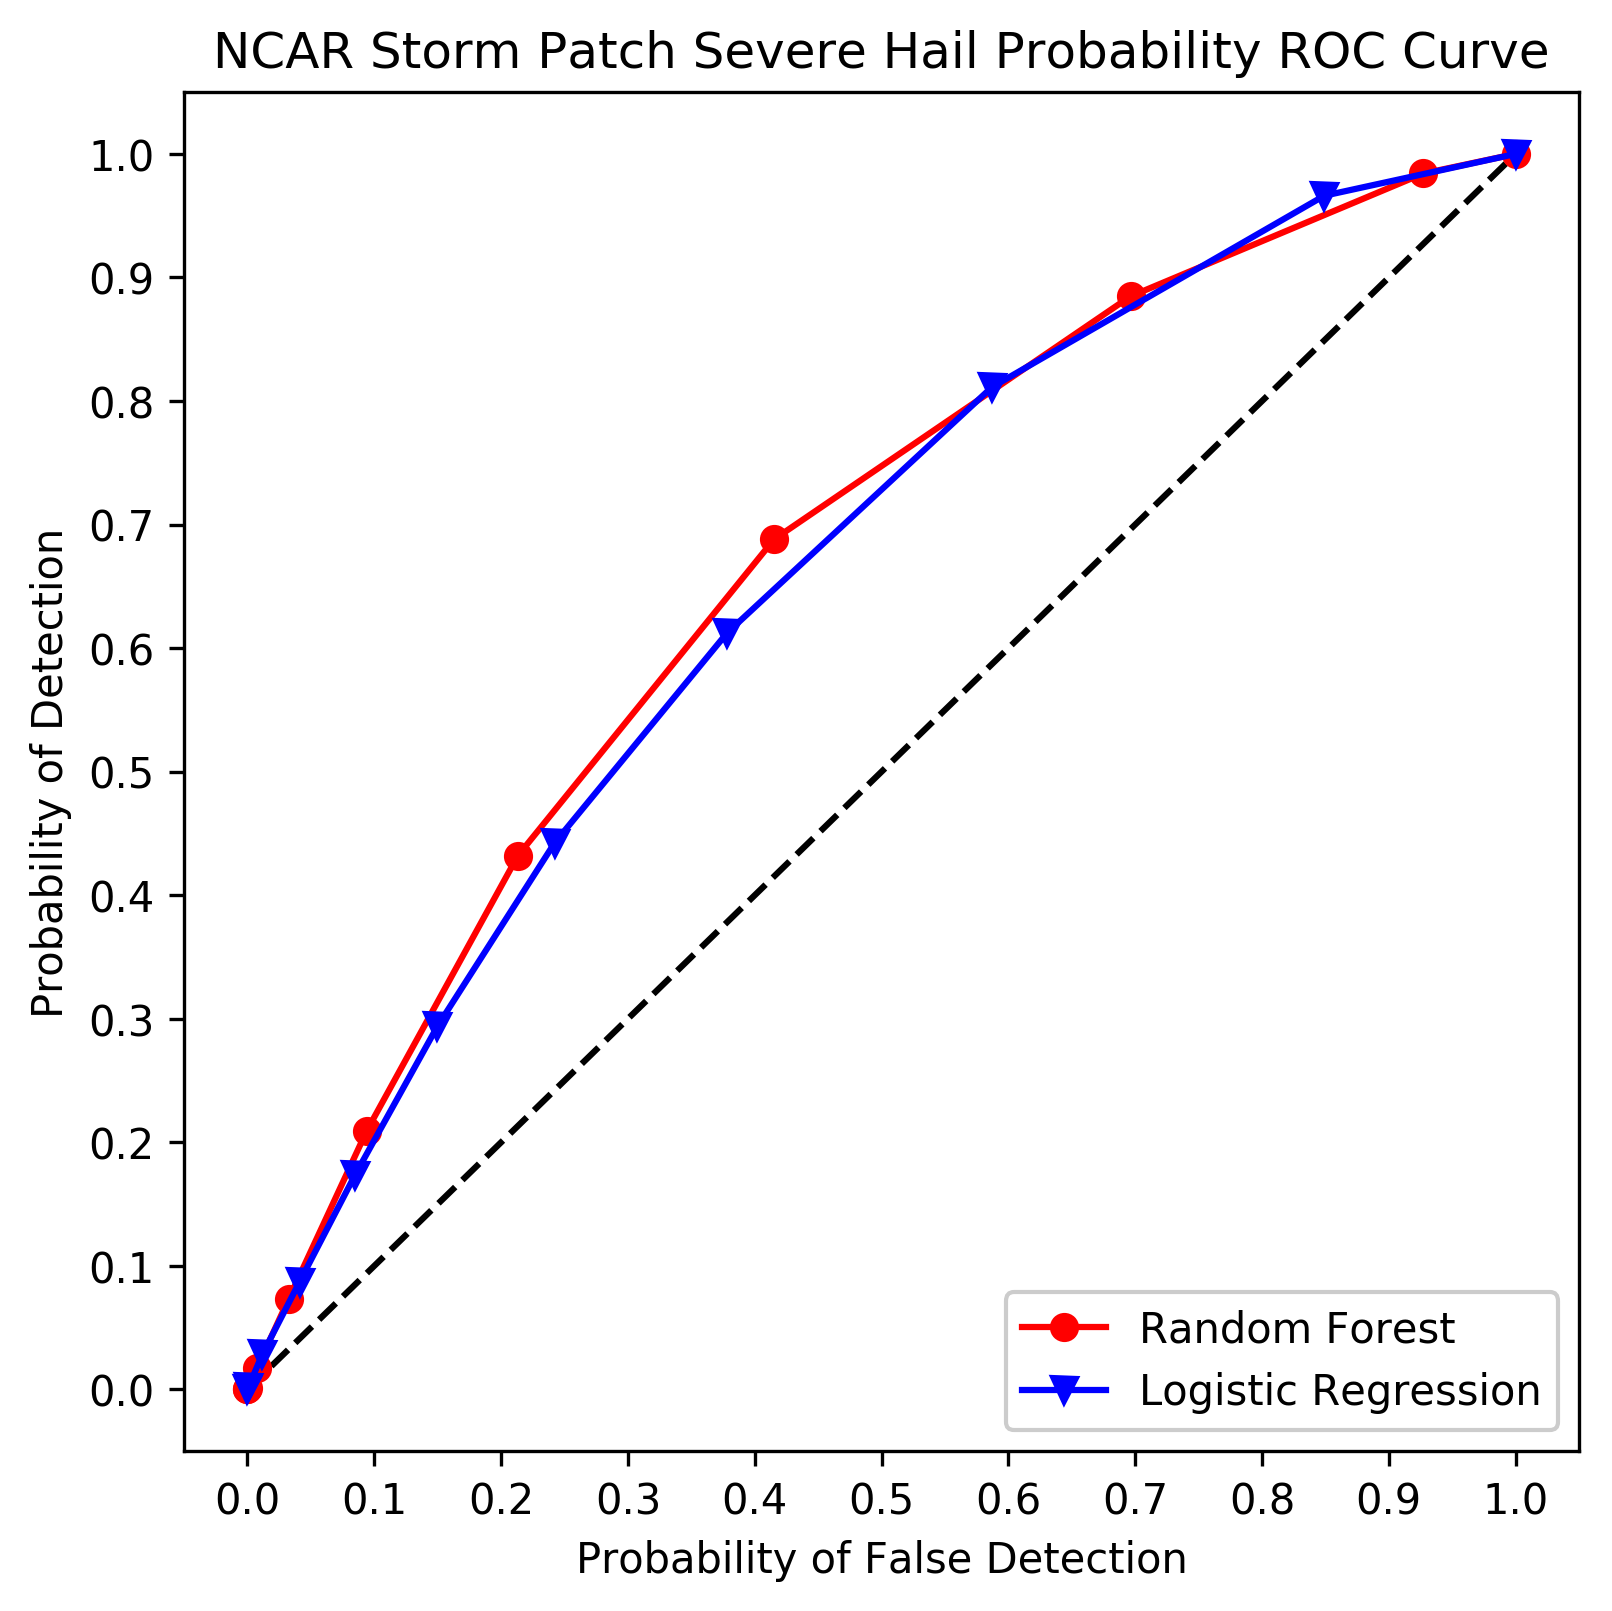

In [11]:
Image("hail_prob_roc.png", height="500px")

In [44]:
rf_rel = DistributedReliability(thresholds=np.arange(0, 1.1, 0.1))
rf_rel.update(rf_preds, test_labels)
logit_rel = DistributedReliability(thresholds=np.arange(0, 1.1, 0.1))
logit_rel.update(logit_preds, test_labels)
print(rf_rel.brier_skill_score(), logit_rel.brier_skill_score())

0.0442903916098 0.0057648435645


In [45]:
attributes_diagram([rf_rel, logit_rel], ["Random Forest", "Logistic Regression"],
                   ["red", "blue"], ["o", "v"], "hail_prob_rel.png", figsize=(6, 6), 
                      title="NCAR Storm Patch Severe Hail Probability Reliability")

/scratch/dgagne/miniconda3/envs/deep/lib/python3.5/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


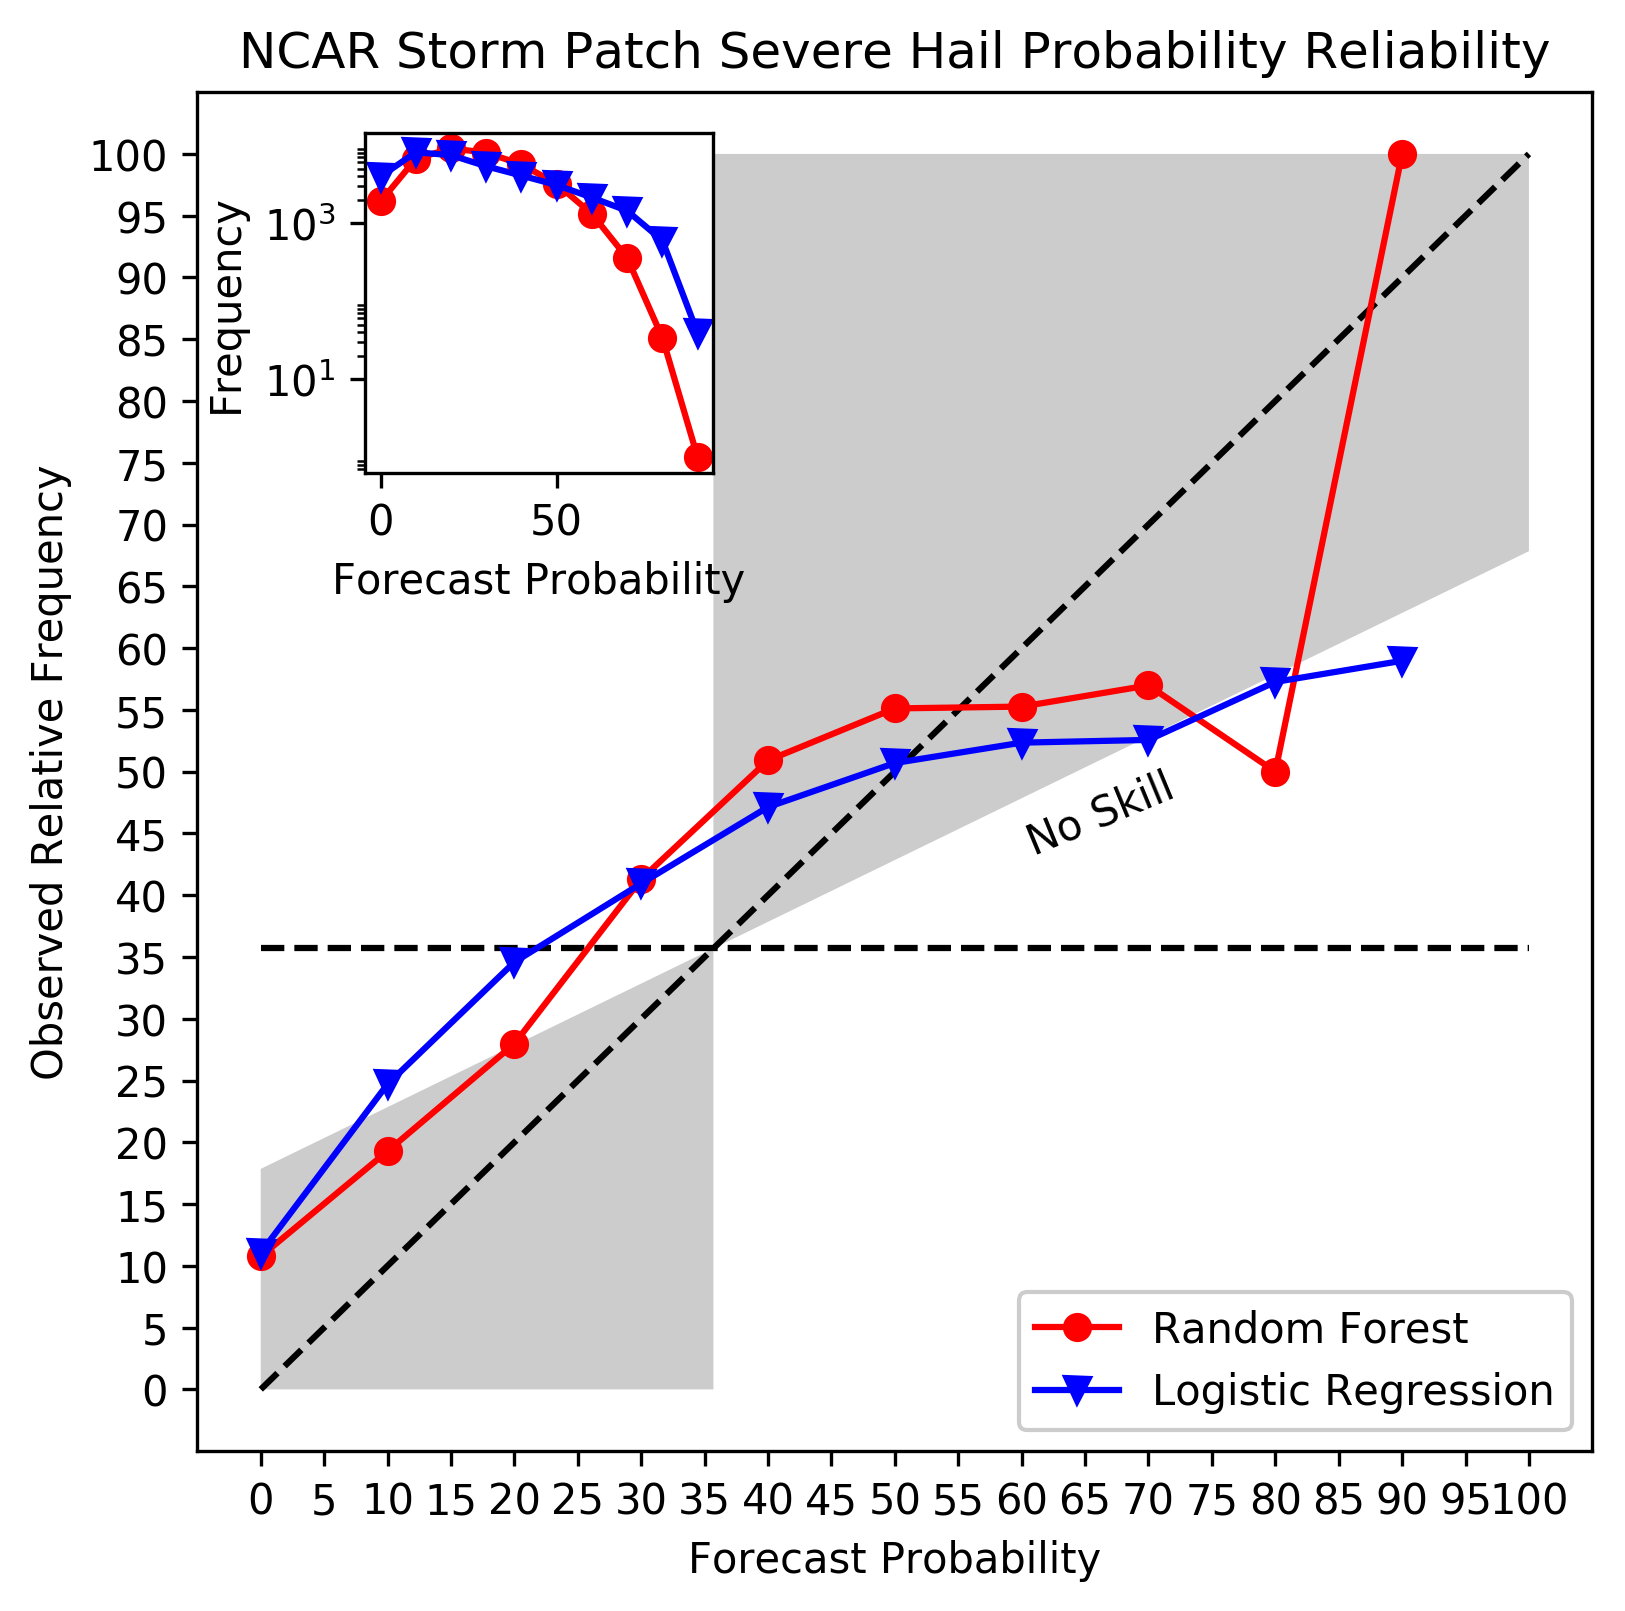

In [46]:
Image("hail_prob_rel.png")

In [218]:
i = 0
for f in range(5):
    for g in range(10):
        print(f, g, rf.feature_importances_[i])
        i += 1

0 0 0.029769374336
0 1 0.0229218584807
0 2 0.0191819303443
0 3 0.0190074045799
0 4 0.0190764015707
0 5 0.0191413043682
0 6 0.0163397488766
0 7 0.0155629552912
0 8 0.0168175598434
0 9 0.0172433324248
1 0 0.0598858619782
1 1 0.0234900844755
1 2 0.0191107043866
1 3 0.017886477526
1 4 0.0169378463512
1 5 0.0193700432037
1 6 0.0178497173052
1 7 0.0152138667484
1 8 0.0164690165982
1 9 0.0161628491396
2 0 0.0459985792386
2 1 0.024606694678
2 2 0.0219315511601
2 3 0.0170269901808
2 4 0.0172493274035
2 5 0.0156226568298
2 6 0.0163031027463
2 7 0.0154156165846
2 8 0.0171270198752
2 9 0.015992684139
3 0 0.0499961019237
3 1 0.0184632567262
3 2 0.0217224133615
3 3 0.0173440765339
3 4 0.0162468282906
3 5 0.0148681474963
3 6 0.0148607349219
3 7 0.0153848752411
3 8 0.0153677381097
3 9 0.0145026925945
4 0 0.0247942555725
4 1 0.0198102811841
4 2 0.0209330207186
4 3 0.0171594549657
4 4 0.0197112242473
4 5 0.0154211186883
4 6 0.0145522567509
4 7 0.0152190225191
4 8 0.0146746689796
4 9 0.0142552705102


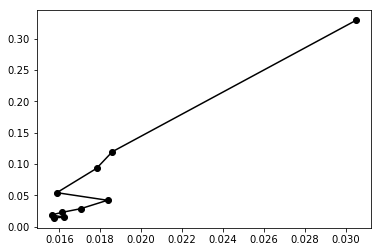

In [81]:
plt.plot(rf.feature_importances_[:10], pc_objs[1].explained_variance_ratio_, 'ko-')

In [83]:
pc_objs[0].explained_variance_ratio_

array([ 0.32953609,  0.11959258,  0.09301332,  0.05424811,  0.04212579,
        0.02868085,  0.02267651,  0.01879894,  0.01506675,  0.01394645])